In [18]:
#!pip install scikit-learn 


In [19]:
# import  libraries
from openai import OpenAI
import pandas as pd
from pprint import pprint

# OpenAI embeddings

Prerequisite: `OPENAI_API_KEY` (and some python libraries)

In [20]:
import json


client = OpenAI()

def get_embedding(text):
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )
    return response.data[0].embedding

# What is an Embedding?

In [21]:
# test the function, and print embedding shape for sample text
#text = "We are at Fort Lewis in Durango, Colorado in a session about embeddings."
text = "Yankee Doodle Dandy"

embedding = get_embedding(text)
print(f"Embedding shape: {len(embedding)}")
# pretty print the embedding with line breaks, etc
pprint(embedding, indent=2, width=80)


Embedding shape: 1536
[ 0.0011933117639273405,
  -0.013511157594621181,
  -0.054305464029312134,
  0.009226973168551922,
  -0.020853610709309578,
  0.02530081570148468,
  -0.00029934680787846446,
  0.006240433547645807,
  -0.037794724106788635,
  -0.04110730439424515,
  -0.015806488692760468,
  -0.019419029355049133,
  0.01459361519664526,
  0.024713942781090736,
  -0.016315113753080368,
  0.03213464468717575,
  -0.015676073729991913,
  -0.03855114057660103,
  0.039724890142679214,
  -0.02583552524447441,
  0.022079527378082275,
  0.010107285343110561,
  -0.0440286360681057,
  -0.020488444715738297,
  0.015284823253750801,
  0.04405472055077553,
  -0.03085656277835369,
  -0.00978776440024376,
  0.040716055780649185,
  -0.04350697249174118,
  -0.023592358455061913,
  -0.03636014088988304,
  -0.007081620395183563,
  -0.03085656277835369,
  -0.0025105192326009274,
  -0.028091730549931526,
  0.018453946337103844,
  -0.03083048015832901,
  -0.04747163504362106,
  -0.01475011557340622,
  0.0

# Read Data Barn Delights Data

In [22]:
# read json objects, line by line, in json/data-barn-delights.jsonl into a dataframe
df = pd.read_json('json/data-barn-delights.jsonl', lines=True)

# Embed all products

In [23]:
# create a new column, named embedding in the dataframe calling get_embedding for text column
df['embedding'] = df['text'].apply(get_embedding)

# Distance TEXT and PRODUCTS x 2

In [24]:
# Define two product IDs and custom text
product1_id = 'apple'
product2_id = 'sports-drink' 
custom_text = "23 chicago bulls"

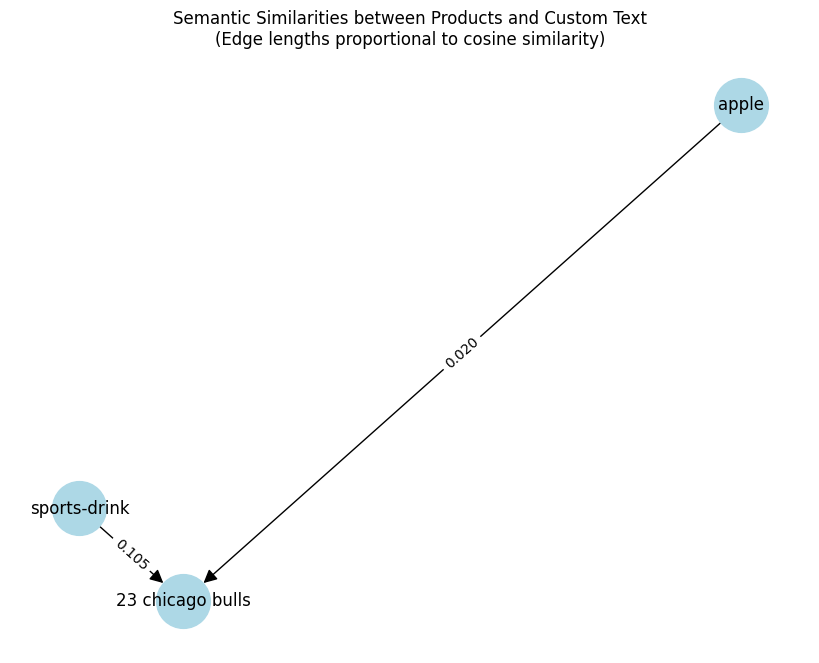

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np



# Get embeddings for the two products from dataframe
product1_data = df[df['id'] == product1_id]
product2_data = df[df['id'] == product2_id]

# Get embedding for custom text
custom_embedding = get_embedding(custom_text)

if len(product1_data) == 0 or len(product2_data) == 0:
    print(f"Error: Could not find {product1_id} or {product2_id} in the dataset")
else:
    product1_embedding = product1_data['embedding'].values[0]
    product2_embedding = product2_data['embedding'].values[0]

    # Calculate cosine similarities
    p1_custom_sim = cosine_similarity([product1_embedding], [custom_embedding])[0][0]
    p2_custom_sim = cosine_similarity([product2_embedding], [custom_embedding])[0][0]

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges with distances
    G.add_edge(product1_id, custom_text[:20], weight=p1_custom_sim)
    G.add_edge(product2_id, custom_text[:20], weight=p2_custom_sim)

    # Draw the graph
    plt.figure(figsize=(8, 6))
    
    # Create a layout where edge lengths are directly proportional to similarities
    pos = {}
    pos[custom_text[:20]] = np.array([0, 0])  # Place custom text at origin
    
    # Calculate positions based on similarities
    # Higher similarity = shorter distance
    angle_p1 = np.pi/3  # 60 degrees
    angle_p2 = 2*np.pi/3  # 120 degrees
    
    # Scale factor for visualization (inverse of similarity for distance)
    scale = 3.0
    
    pos[product1_id] = np.array([
        scale * (1/p1_custom_sim) * np.cos(angle_p1),
        scale * (1/p1_custom_sim) * np.sin(angle_p1)
    ])
    pos[product2_id] = np.array([
        scale * (1/p2_custom_sim) * np.cos(angle_p2),
        scale * (1/p2_custom_sim) * np.sin(angle_p2)
    ])

    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=1500, arrowsize=20, font_size=12)

    # Add edge labels (similarities)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    edge_labels = {k: f'{v:.3f}' for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title('Semantic Similarities between Products and Custom Text\n(Edge lengths proportional to cosine similarity)')
    plt.show()

# Semantic Search (simplified)

In [26]:
# Define a query text
query_text = "Scrub my floors"

# Get query embedding using the same model used for products
query_embedding = get_embedding(query_text)

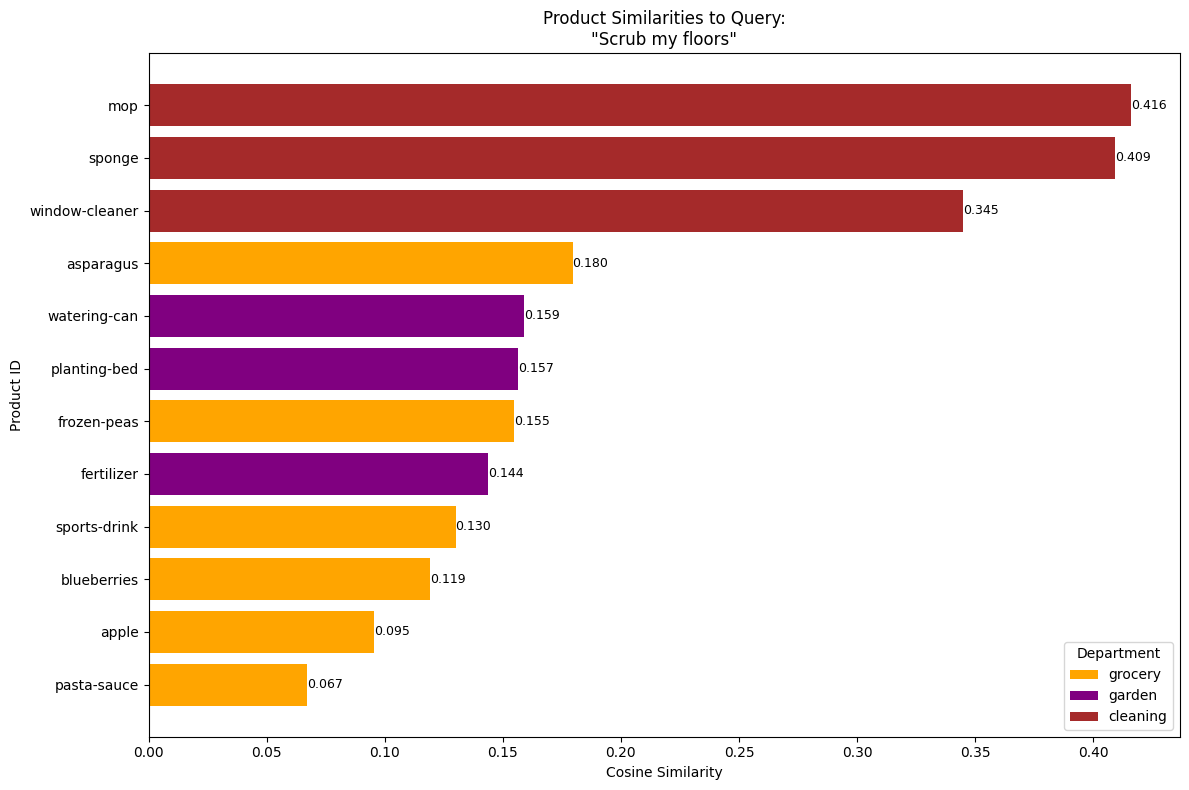

In [27]:


# Calculate cosine similarities with all products
similarities = []
for emb in df['embedding']:
    sim = cosine_similarity([query_embedding], [emb])[0][0]
    similarities.append(sim)

# Add similarities to dataframe
df['similarity_score'] = similarities

# Sort by similarity
df_sorted = df.sort_values('similarity_score', ascending=True)

# Create color mapping for departments
department_colors = {
    'grocery': 'orange',
    'garden': 'purple',
    'cleaning': 'brown'
}

# Create horizontal bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(df_sorted['id'], df_sorted['similarity_score'], 
                color=[department_colors[d] for d in df_sorted['meta_department']])

# Customize the plot
plt.xlabel('Cosine Similarity')
plt.ylabel('Product ID')
plt.title(f'Product Similarities to Query:\n"{query_text}"')

# Add legend
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=dept) 
                  for dept, color in department_colors.items()]
plt.legend(handles=legend_elements, title='Department', loc='lower right')

# Add value labels on the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', 
             ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()


# Recommendation System (simplified)

In [28]:
from IPython.display import HTML

def create_recommendation_interface(query_id, n=4):
    # Get query embedding
    query_embedding = df[df['id'] == query_id]['embedding'].iloc[0]
    
    # Calculate similarities
    similarities = []
    for emb in df['embedding']:
        sim = cosine_similarity([query_embedding], [emb])[0][0]
        similarities.append(sim)
    
    # Add to df and sort
    df['similarity'] = similarities
    query_item = df[df['id'] == query_id]
    results = df.sort_values('similarity', ascending=False)[1:n+1] # Skip first since it's the query
    
    # Get max similarity for scaling
    max_sim = results['similarity'].max()
    
    # Generate HTML
    html = f"""
    <style>
        .recommendations {{
            display: flex;
            flex-direction: column;
            align-items: center;
            gap: 30px;
            font-family: sans-serif;
        }}
        .query-card {{
            border: 1px solid #444;
            border-radius: 8px;
            padding: 20px;
            background: #2d2d2d;
            color: white;
            box-shadow: 2px 2px 12px rgba(0,0,0,0.2);
            width: 100%;
            max-width: 600px;
            display: flex;
            gap: 20px;
            align-items: center;
        }}
        .query-card img {{
            width: 250px;
            height: 250px;
            object-fit: cover;
            border-radius: 4px;
        }}
        .query-details {{
            flex: 1;
        }}
        .results-container {{
            display: flex;
            flex-wrap: wrap;
            gap: 20px;
            justify-content: center;
            width: 100%;
        }}
        .card {{
            border: 1px solid #ddd;
            border-radius: 8px;
            padding: 15px;
            background: white;
            box-shadow: 2px 2px 8px rgba(0,0,0,0.1);
            transition: transform 0.2s;
        }}
        .card:hover {{
            transform: translateY(-5px);
        }}
        .card img {{
            width: 200px;
            height: 200px;
            object-fit: cover;
            border-radius: 4px;
        }}
        .similarity {{
            color: #666;
            font-size: 0.9em;
        }}
        .product-text {{
            margin-top: 10px;
            font-size: 0.9em;
            max-width: 200px;
        }}
    </style>
    <div class="recommendations">
        <div class="query-card">
            <img src="img/{query_item['id'].iloc[0]}.webp" alt="{query_item['id'].iloc[0]}">
            <div class="query-details">
                <h2>{query_item['id'].iloc[0]}</h2>
                <div class="product-text" style="color: #ddd; max-width: none;">
                    {query_item['text'].iloc[0]}
                </div>
            </div>
        </div>
        <div class="results-container">
    """
    
    for _, row in results.iterrows():
        # Calculate scale based on similarity score (0.5 to 1.0)
        scale = 0.5 + (0.5 * (row['similarity'] / max_sim))
        
        html += f"""
        <div class="card" style="transform: scale({scale})">
            <img src="img/{row['id']}.webp" alt="{row['id']}">
            <h3>{row['id']}</h3>
            <div class="similarity">Similarity: {row['similarity']:.5f}</div>
            <div class="product-text">{row['text']}</div>
        </div>
        """
    
    html += "</div></div>"
    return HTML(html)


In [29]:
# Example usage
create_recommendation_interface('apple')

# Retrieval Augmented Generation (simplified)

In [30]:
from openai import OpenAI
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import HTML


def find_similar_products(query, df, n=3):
    # Get embedding for query
    query_embedding = get_embedding(query)
    
    # Calculate cosine similarity between query and all products
    similarities = []
    for emb in df['embedding']:
        similarity = cosine_similarity([query_embedding], [emb])[0][0]
        similarities.append(similarity)
    
    # Add similarities to temp df
    temp_df = df.copy()
    temp_df['similarity'] = similarities
    
    # Sort and get top N results
    results = temp_df.nlargest(n, 'similarity')
    return results

def generate_answer(query, context, client=OpenAI()):
    prompt = f"""Based on the following product information, answer this question: {query}

Context from relevant products:
{context}

Answer:"""

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

def rag_interface(query):
    # Find similar products
    results = find_similar_products(query, df)
    
    # Build context from results
    context = "\n\n".join([
        f"Product: {row['id']}\n"
        f"Description: {row['text']}"
        for _, row in results.iterrows()
    ])
    
    # Generate answer
    answer = generate_answer(query, context)
    
    # Generate HTML output
    html = f"""
    <style>
        .rag-container {{
            max-width: 800px;
            margin: 20px auto;
            font-family: Arial, sans-serif;
        }}
        .query {{
            background: #f5f5f5;
            padding: 15px;
            border-radius: 5px;
            margin-bottom: 20px;
        }}
        .answer {{
            background: #e8f4f8;
            padding: 15px;
            border-radius: 5px;
            margin-bottom: 20px;
        }}
        .context {{
            background: #fff;
            padding: 15px;
            border: 1px solid #ddd;
            border-radius: 5px;
        }}
        .product {{
            margin: 10px 0;
            padding: 10px;
            border-left: 3px solid #2196F3;
        }}
    </style>
    <div class="rag-container">
        <div class="query">
            <h3>Query:</h3>
            <p>{query}</p>
        </div>
        <div class="context">
            <h3>Retrieval Augmentation:</h3>
            {' '.join([f'''
            <div class="product">
                <strong>{row['id']}</strong> (Similarity: {row['similarity']:.3f})
                <p>{row['text']}</p>
            </div>
            ''' for _, row in results.iterrows()])}
        </div>
        <div class="answer">
            <h3>Generated Response:</h3>
            <p>{answer}</p>
        </div>
    </div>
    """
    return HTML(html)



In [31]:
# Example usage
query = "How can I keep hydrated when exercising?"
rag_interface(query)

# Visualize Embeddings for mere mortals

/Users/ngoodman/.pyenv/versions/notebooks/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


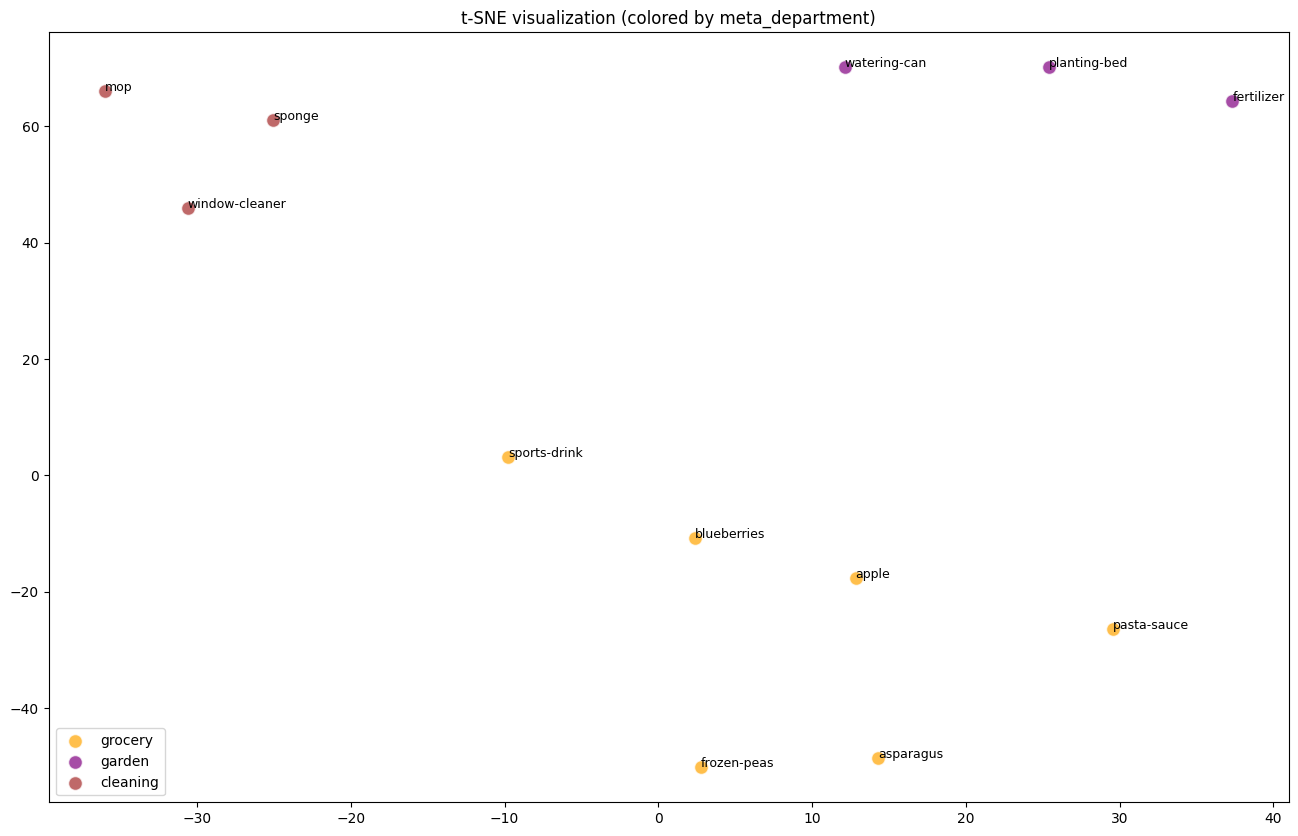

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Sample dataframe based on the provided data

# Convert embeddings to numpy array
embeddings = np.array(df['embedding'].tolist())

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=3, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Add t-SNE results to dataframe
df['tsne-2d-one'] = embeddings_2d[:,0]
df['tsne-2d-two'] = embeddings_2d[:,1]

# Function to plot t-SNE with labels
def plot_tsne(df, label_col, title):
    plt.figure(figsize=(16, 10))
    colors = {'red': 'red', 'green': 'green', 'blue': 'blue'}
    departments = {'grocery': 'orange', 'garden': 'purple', 'cleaning': 'brown'}
    if label_col == 'meta_color':
        color_map = colors
    else:
        color_map = departments
    
    for i in range(len(df)):
        plt.scatter(df['tsne-2d-one'][i], df['tsne-2d-two'][i], c=color_map[df[label_col][i]], label=df[label_col][i], alpha=0.7, edgecolors='w', s=100)
        plt.text(df['tsne-2d-one'][i]+0.01, df['tsne-2d-two'][i]+0.01, df['id'][i], fontsize=9)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title(title)
    plt.show()

# Plot t-SNE based on color
#plot_tsne(df, 'meta_color', 't-SNE visualization (colored by meta_color)')

# Plot t-SNE based on department
plot_tsne(df, 'meta_department', 't-SNE visualization (colored by meta_department)')
